In [1]:
#%% load basic model
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

from models.dino import utils
from models.dino import vision_transformer as vits

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

arch = 'vit_small'
patch_size = 8
pretrained_weights = 'checkpoints/B14_vits8_dinomm_ep99.pth'
checkpoint_key = 'teacher'
threshold = None

data_path = 'datasets/dataload_op1_lmdb/train_B14.lmdb'
image_path = '.'

model = vits.__dict__[arch](patch_size=8, num_classes=0, in_chans = 14)
for p in model.parameters():
    p.requires_grad = False
model.eval()

state_dict = torch.load(pretrained_weights, map_location="cpu")
state_dict = state_dict[checkpoint_key]
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
msg = model.load_state_dict(state_dict, strict=False)

from datasets.BigEarthNet.bigearthnet_dataset_seco_lmdb_B14 import LMDBDataset
from cvtorchvision import cvtransforms

train_dataset = LMDBDataset(
        lmdb_file='datasets/dataload_op1_lmdb/train_B14.lmdb',
        transform=cvtransforms.Compose([cvtransforms.ToTensor()])
    )
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True,num_workers=0)

test_dataset = LMDBDataset(
        lmdb_file='datasets/dataload_op1_lmdb/train_B14.lmdb',
        transform=cvtransforms.Compose([cvtransforms.ToTensor()])
    )

test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True,num_workers=0)


NEW_LABELS = [
    'Urban fabric',
    'Industrial or commercial units',
    'Arable land',
    'Permanent crops',
    'Pastures',
    'Complex cultivation patterns',
    'Land principally occupied by agriculture, with significant areas of natural vegetation',
    'Agro-forestry areas',
    'Broad-leaved forest',
    'Coniferous forest',
    'Mixed forest',
    'Natural grassland and sparsely vegetated areas',
    'Moors, heathland and sclerophyllous vegetation',
    'Transitional woodland/shrub',
    'Beaches, dunes, sands',
    'Inland wetlands',
    'Coastal wetlands',
    'Inland waters',
    'Marine waters'
]

for idx, (imgs,target) in enumerate(train_loader):
    if idx>45:
        break
img = imgs[0]
img1 = imgs[0].permute(1, 2, 0)

#print(target)
target_name = [NEW_LABELS[idd] for idd in range(19) if target[0,idd]]
    
channels = {
    "B01": img1[:,:,0],
    "B02": img1[:,:,1],
    "B03": img1[:,:,2],
    "B04": img1[:,:,3],
    "B05": img1[:,:,4],
    "B06": img1[:,:,5],
    "B07": img1[:,:,6],
    "B08": img1[:,:,7],
    "B8A": img1[:,:,8],
    "B09": img1[:,:,9],
    "B11": img1[:,:,10],
    "B12": img1[:,:,11],
    "VH": img1[:,:,12],
    "VV": img1[:,:,13]
}

w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

print(w,h,w_featmap,h_featmap)
print(img.shape)

def preprocess_data(data):
    # 检查输入是否为 NumPy 数组，如果是则转换为 PyTorch 张量
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data).float()
    elif isinstance(data, torch.Tensor):
        data = data.float()
    else:
        raise TypeError("Expected input type is np.ndarray or torch.Tensor, but got {}".format(type(data)))

    # 选择前 14 个通道
    if data.shape[1] == 16:
        data = data[:, :14, :, :]
    
    return data

img = preprocess_data(img)

attentions = model.get_last_selfattention(img)
nh = attentions.shape[1]
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
if threshold is not None:
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
print(attentions.shape)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
print(attentions.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)


import torch
import torch.nn as nn

class FeatureExtractingModel(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractingModel, self).__init__()
        # 假设原始模型的最后一个模块是分类头，我们将其之前的所有模块作为特征提取器
        self.feature_extractor = nn.Sequential(*list(original_model.children())[:-1])

    def forward(self, x):
        # 显式处理每一层
        for module in self.feature_extractor:
            if isinstance(module, nn.ModuleList):
                # 如果是ModuleList，需要进一步迭代其内部模块
                for sub_module in module:
                    x = sub_module(x)
            else:
                # 直接调用模块
                x = module(x)
        return x


feature_model = FeatureExtractingModel(model)

C:\ProgramData\Anaconda3\envs\hot\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\ProgramData\Anaconda3\envs\hot\lib\site-packages\cvtorchvision\cvtransforms\cvfunctional.py:60: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1)))


128 128 16 16
torch.Size([1, 16, 128, 128])
torch.Size([6, 16, 16])
(6, 128, 128)
Using device: cuda


Total qualified labels: 4
Total qualified labels: 6
Total qualified labels: 6
Total qualified labels: 7
Total qualified labels: 10
Total qualified labels: 11
Total qualified labels: 12
Total qualified labels: 12
Total qualified labels: 13
Total qualified labels: 14
Total qualified labels: 14
Total qualified labels: 15
Total qualified labels: 15
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 17
Total qualified labels: 18
Total qualified labels: 18
Total qualified labels: 18
Total qualified labels: 18
Total qualified labels: 18
Total qualified labels: 18
Total qualified labels: 18
Total qualified labels: 18
Total qualified labels: 18
Total

C:\ProgramData\Anaconda3\envs\hot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\ProgramData\Anaconda3\envs\hot\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


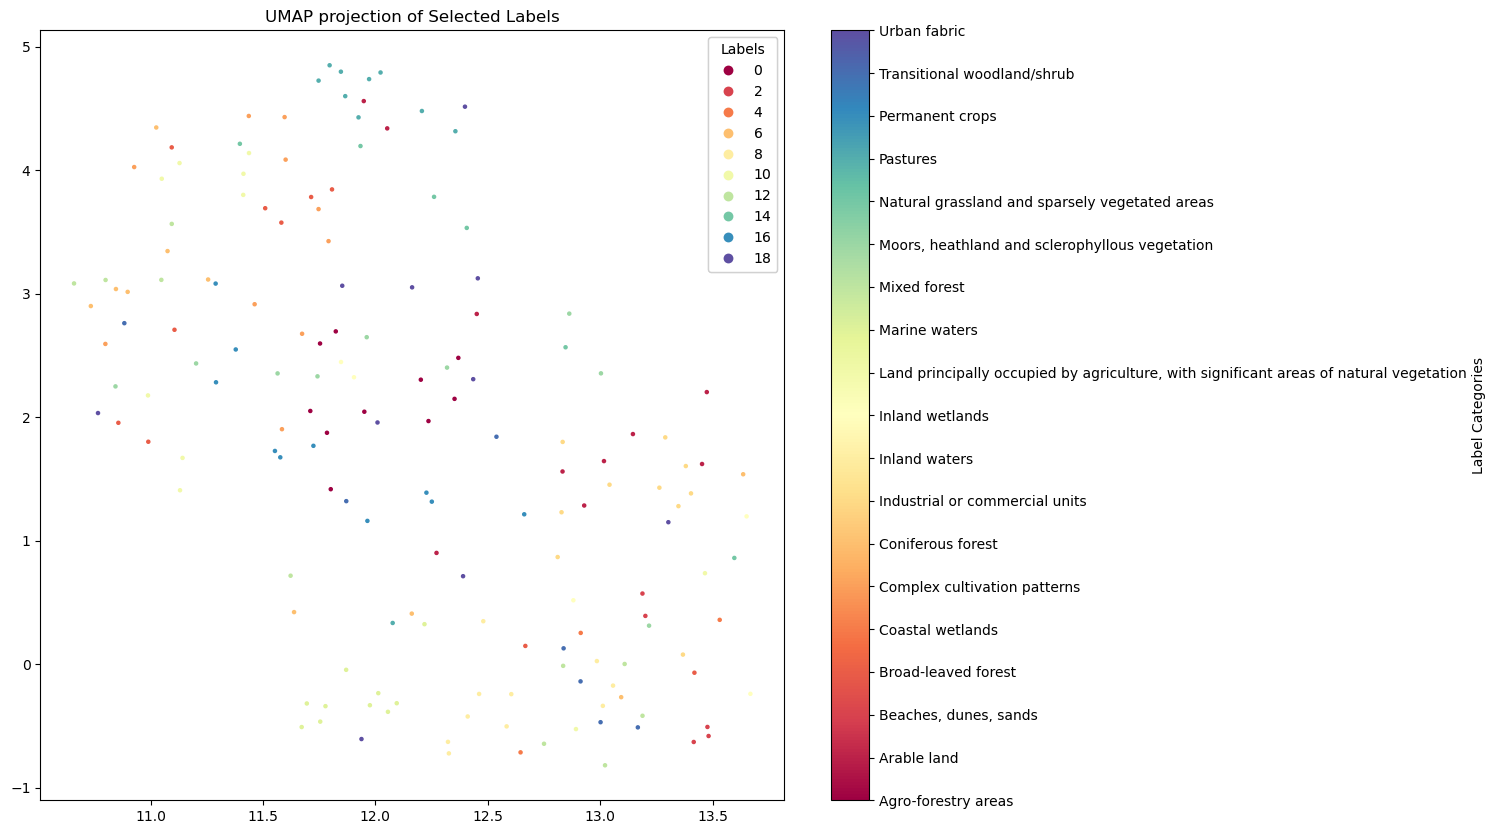

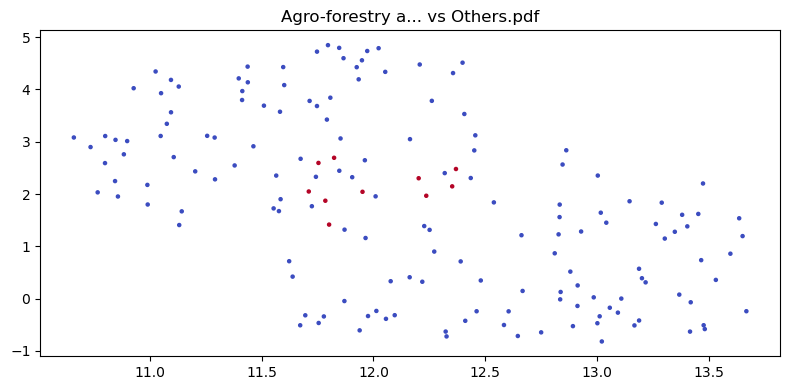

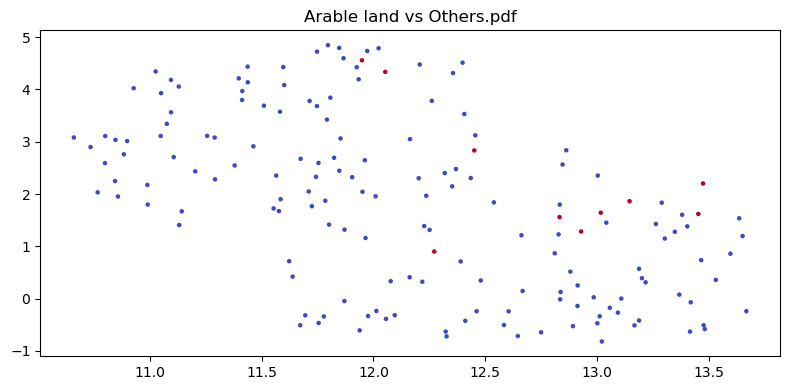

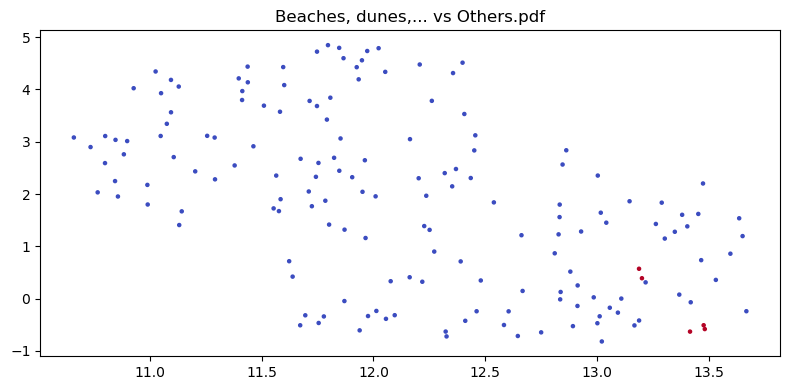

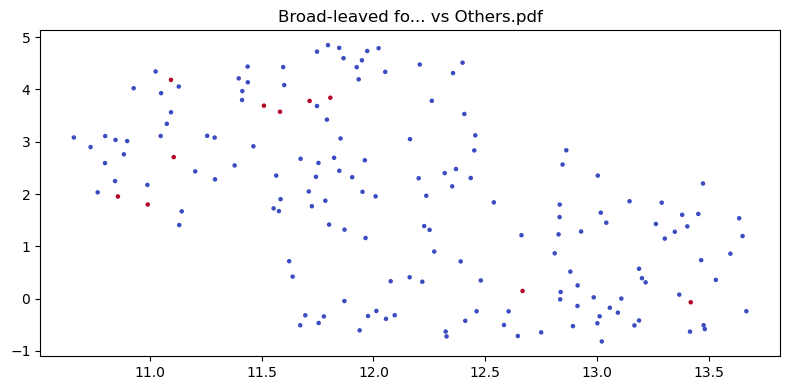

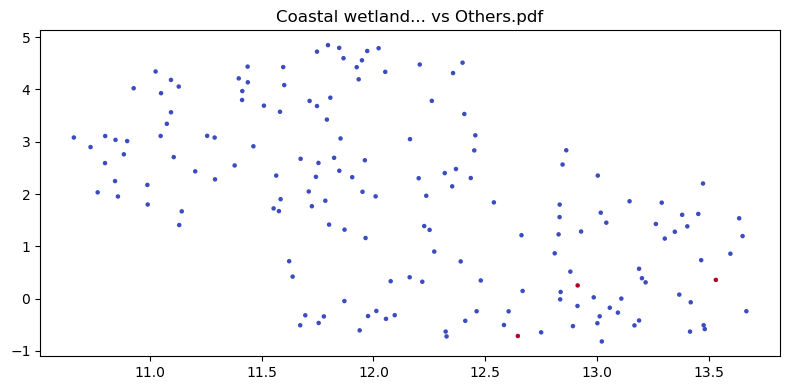

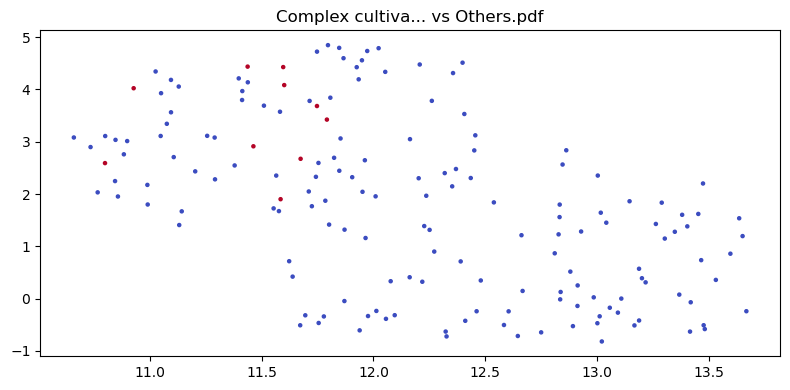

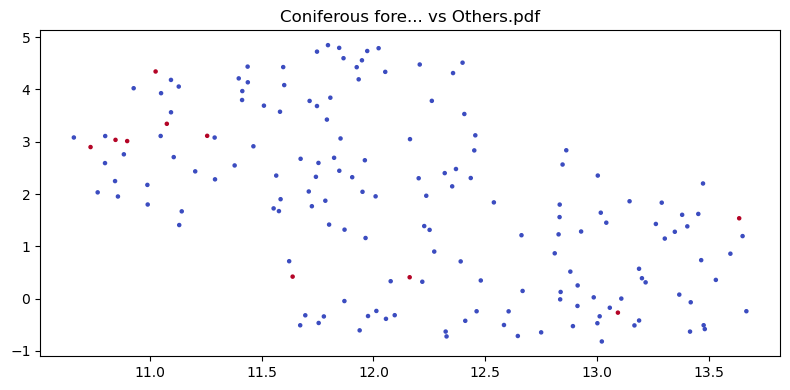

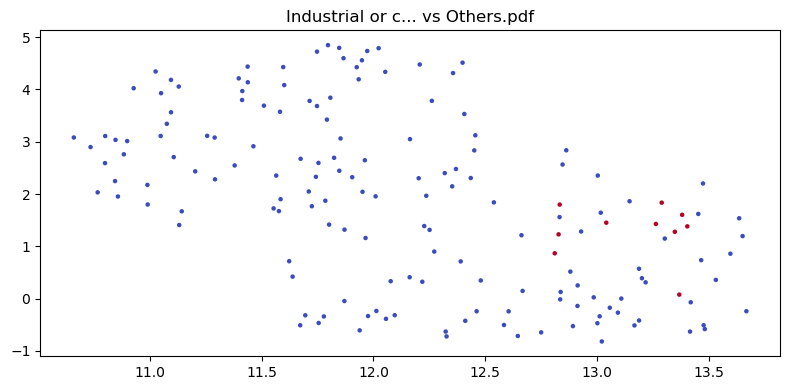

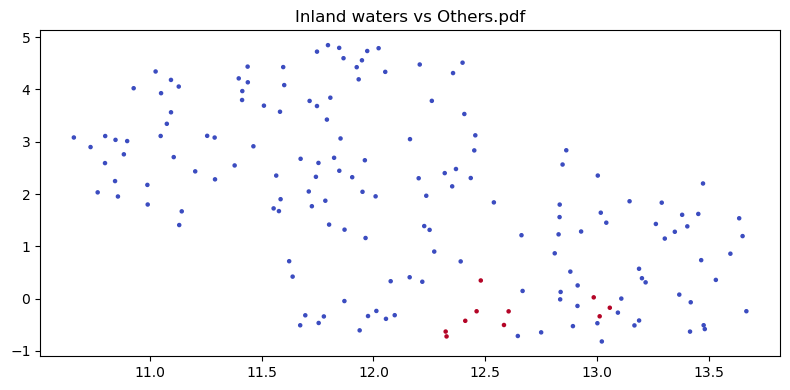

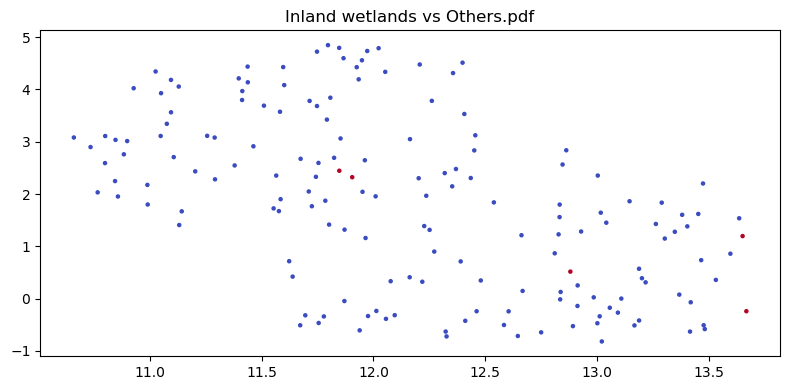

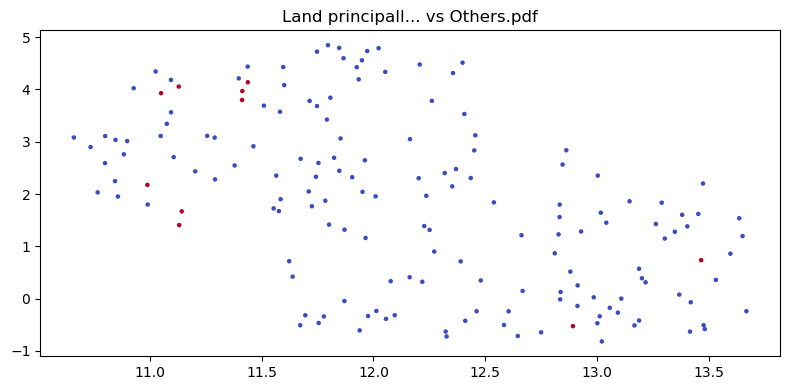

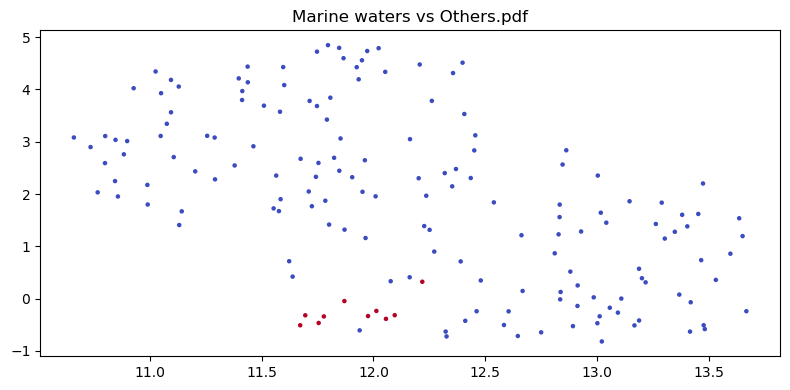

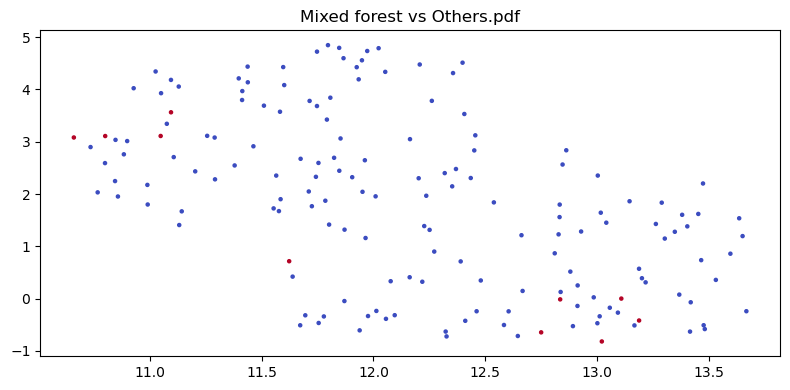

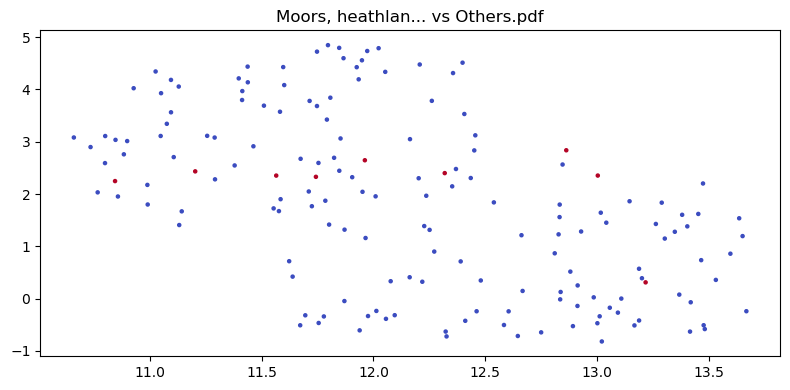

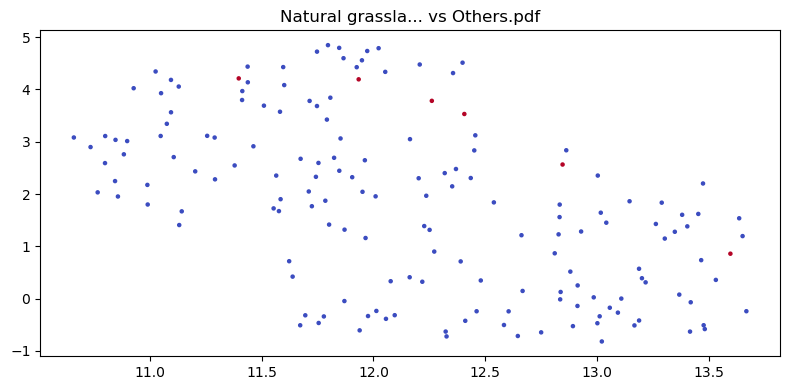

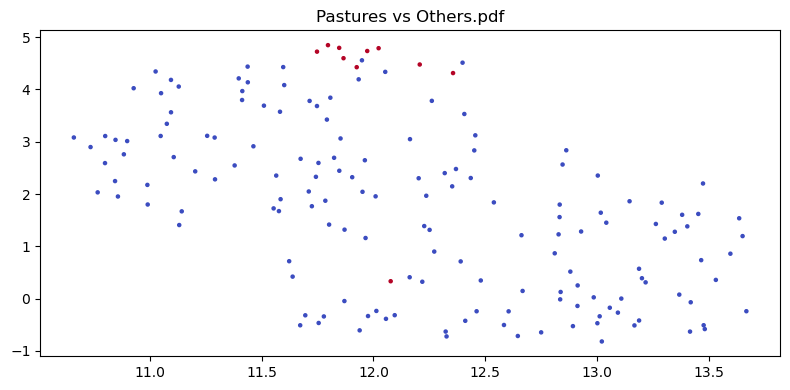

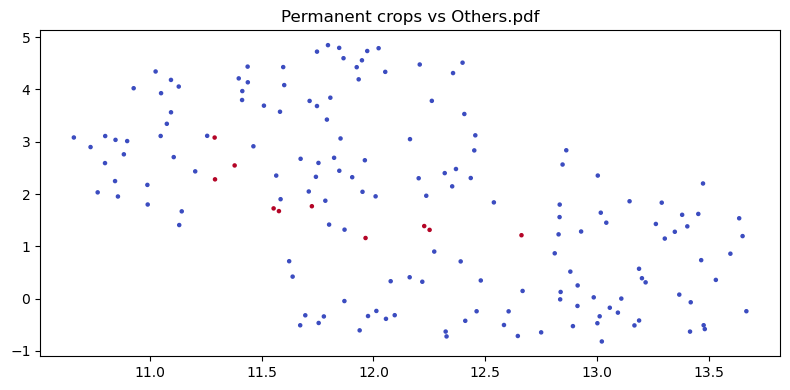

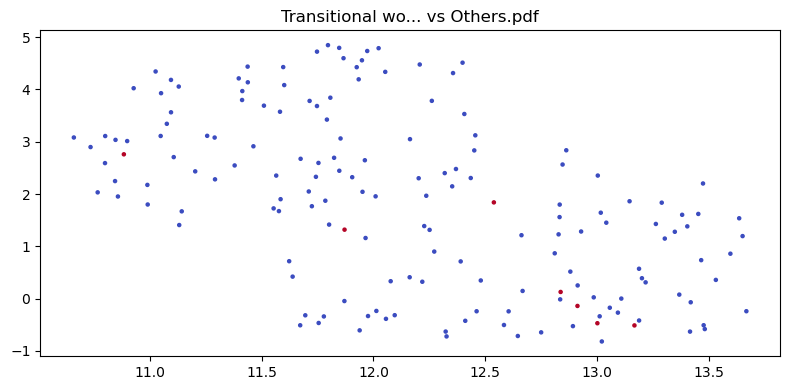

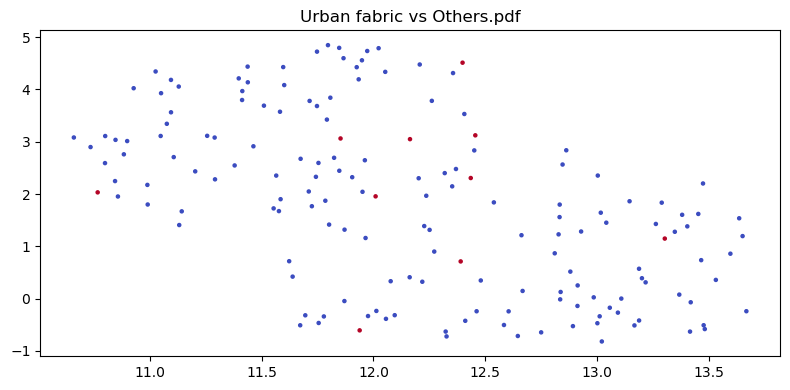

In [2]:
#%% visulaisation
import torch
import numpy as np
from collections import defaultdict

features = []
labels = []
label_count = defaultdict(int) 
min_labels = 19  
min_samples_per_label = 3 
max_samples_per_label = 10  
qualified_labels = set() 

with torch.no_grad():
    for i, (imgs, target) in enumerate(train_loader):
        imgs = imgs.to(device)
        if imgs.shape[1] != 14:
            imgs = imgs[:, :14, :, :]
        feature = feature_model(imgs)  # 获取特征
        batch_features = feature.view(feature.size(0), -1).cpu().numpy()
        batch_labels = [[NEW_LABELS[idx] for idx, label in enumerate(t) if label == 1] for t in target.cpu().numpy()]
        
        for feat, label_list in zip(batch_features, batch_labels):
            if len(label_list) <= 2:  # 只考虑单一标签的样本
                label = label_list[0]
                if label_count[label] < max_samples_per_label:
                    label_count[label] += 1
                    if label_count[label] >= min_samples_per_label:
                        qualified_labels.add(label)
                    features.append(feat)
                    labels.append(label)

        #print(f"After batch {i+1}:")
        print(f"Total qualified labels: {len(qualified_labels)}")
        #for label in qualified_labels:
            #print(f"Label '{label}' has reached {label_count[label]} samples.")

        if len(qualified_labels) >= min_labels:
           print(f"Stopped after processing {i+1} batches: all active labels have reached the minimum sample count.")
           break

# 将列表转换为 NumPy 数组
features = np.vstack(features) if features else np.array([])
labels = np.array(labels, dtype=object)
print("Accumulated features shape:", features.shape)
print("Number of labels collected:", len(labels))


import numpy as np
import umap
import matplotlib.pyplot as plt
from collections import Counter


# Map labels to indices for visualization
unique_labels = sorted(set(labels))  # Convert labels to set for unique labels
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

# Convert label list to indices
label_indices = [label_to_index[label] for label in labels]  # Map each label to its index

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=30, min_dist=0, metric='euclidean', random_state=42)
umap_embedding = reducer.fit_transform(features)

import numpy as np
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm

def truncate_label(label, max_length=15):
    return label[:max_length] + '...' if len(label) > max_length else label

fig, ax = plt.subplots(figsize=(12, 10))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=label_indices, cmap='Spectral', s=5)
legend1 = ax.legend(*scatter.legend_elements(), title="Labels")
ax.add_artist(legend1)
cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)), label='Label Categories').set_ticklabels(unique_labels)
plt.title('UMAP projection of Selected Labels')
plt.savefig('visual.pdf', format='pdf')
plt.show()


for idx, label in enumerate(unique_labels):
    fig, ax = plt.subplots(figsize=(8, 4))  
    specific_label_indices = [1 if lbl == label else 0 for lbl in labels]
    scatter = ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=specific_label_indices, cmap='coolwarm', s=5)
    plt.title(f'{truncate_label(label)} vs Others.pdf')
    plt.tight_layout()
    #plt.savefig(f'{truncate_label(label)} vs Others.pdf', format='pdf')
     

In [3]:
#%% load data from npy
import numpy as np
#train_features = np.load('principal_components.npy',allow_pickle=True)
train_features = np.load('train_principal_components.npy',allow_pickle=True)
train_labels = np.load('train_labels.npy',allow_pickle=True)

test_features = np.load('test_principal_components.npy',allow_pickle=True)
test_labels = np.load('test_labels.npy',allow_pickle=True)


Epoch 1, Train/Test F2 sum: 1.0527/0.7993, Hamming Loss: 0.3819/0.4510
Epoch 2, Train/Test F2 sum: 1.2617/0.9052, Hamming Loss: 0.2910/0.4147
Epoch 3, Train/Test F2 sum: 1.3222/0.9231, Hamming Loss: 0.2513/0.4014
Epoch 4, Train/Test F2 sum: 1.3415/0.9241, Hamming Loss: 0.2356/0.3947
Epoch 5, Train/Test F2 sum: 1.3534/0.9268, Hamming Loss: 0.2246/0.3886
Best F2 sum (Macro F2 + Micro F2): 0.9267846353378214 at epoch 5
Macro F2: 0.41308942125133086, Micro F2: 0.5136952140864905, Hamming Loss: 0.3885792962142399


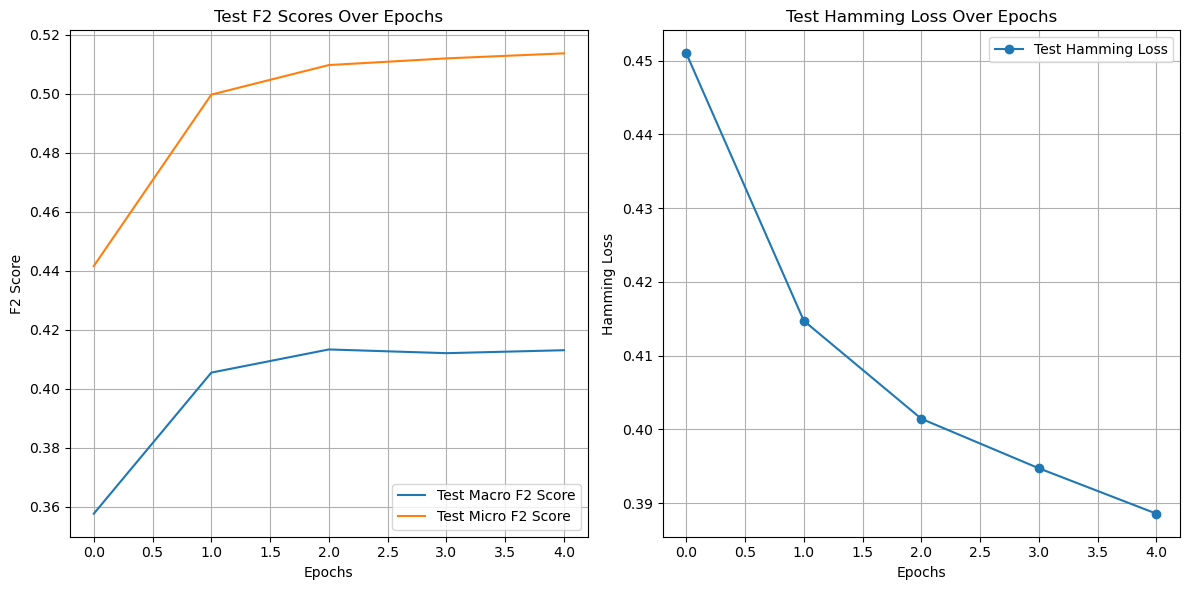

In [4]:
#%% linear probing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


def hamming_loss(y_true, y_pred, threshold=0.5):
    # 将预测概率转换为0或1的预测结果
    y_pred = (y_pred > threshold).float()
    # 计算汉明损失：不一致的标签占总标签的比例
    loss = (y_true != y_pred).float().mean()
    return loss




train_labels_encoded = train_labels
test_labels_encoded = test_labels  # 使用相同的转换

# 转换为Tensor
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels_encoded, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_encoded, dtype=torch.float32)

# 创建TensorDataset和DataLoader
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=2000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2000, shuffle=False)

# 定义模型
class LinearModel(nn.Module):
    def __init__(self, num_features, num_labels):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(num_features, num_labels)

    def forward(self, x):
        return self.linear(x)  # BCEWithLogitsLoss includes the sigmoid activation

model = LinearModel(train_features_tensor.shape[1], train_labels_tensor.shape[1])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

def evaluate_model(model, loader, device):
    macro_f2s, micro_f2s, hammings = [], [], []
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        outputs_sig = torch.sigmoid(outputs).detach().cpu()
        targets = targets.cpu()

        macro_f2 = fbeta_score(targets.numpy(), (outputs_sig > 0.5).numpy(), beta=2, average='macro')
        micro_f2 = fbeta_score(targets.numpy(), (outputs_sig > 0.5).numpy(), beta=2, average='micro')
        hamming = hamming_loss(targets, outputs_sig )

        macro_f2s.append(macro_f2)
        micro_f2s.append(micro_f2)
        hammings.append(hamming.item())

    return {
        'macro_f2': np.mean(macro_f2s),
        'micro_f2': np.mean(micro_f2s),
        'hamming_loss': np.mean(hammings),
        'f2_sum': np.mean(macro_f2s) + np.mean(micro_f2s)
    }


train_f2_scores = []
test_f2_scores = []
train_hamming_losses = []
test_hamming_losses = []
best_f2_sum = float('-inf')
best_details = {}
test_macro_f2_scores = []
test_micro_f2_scores = []

model.train()
for epoch in range(5):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs_sig = torch.sigmoid(outputs)
        loss = nn.BCEWithLogitsLoss()(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_eval = evaluate_model(model, train_loader, device)
        test_eval = evaluate_model(model, test_loader, device)
        test_macro_f2_scores.append(test_eval['macro_f2'])
        test_micro_f2_scores.append(test_eval['micro_f2'])

        if test_eval['f2_sum'] > best_f2_sum:
            best_f2_sum = test_eval['f2_sum']
            best_details = {
                'epoch': epoch + 1,
                'test_macro_f2': test_eval['macro_f2'],
                'test_micro_f2': test_eval['micro_f2'],
                'test_hamming_loss': test_eval['hamming_loss']
            }

        train_f2_scores.append(train_eval['f2_sum'])
        test_f2_scores.append(test_eval['f2_sum'])
        train_hamming_losses.append(train_eval['hamming_loss'])
        test_hamming_losses.append(test_eval['hamming_loss'])

        print(f'Epoch {epoch+1}, Train/Test F2 sum: {train_eval["f2_sum"]:.4f}/{test_eval["f2_sum"]:.4f}, '
              f'Hamming Loss: {train_eval["hamming_loss"]:.4f}/{test_eval["hamming_loss"]:.4f}')

# 输出最优结果
print(f'Best F2 sum (Macro F2 + Micro F2): {best_f2_sum} at epoch {best_details["epoch"]}')
print(f'Macro F2: {best_details["test_macro_f2"]}, Micro F2: {best_details["test_micro_f2"]}, '
      f'Hamming Loss: {best_details["test_hamming_loss"]}')

# 可视化结果


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(test_macro_f2_scores, label='Test Macro F2 Score')
plt.plot(test_micro_f2_scores, label='Test Micro F2 Score')
plt.title('Test F2 Scores Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F2 Score')
plt.legend()
plt.grid(True)


# 绘制汉明损失图表
plt.subplot(1, 2, 2)
plt.plot(test_hamming_losses, label='Test Hamming Loss', marker='o')
plt.title('Test Hamming Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Hamming Loss')
plt.legend()
plt.grid(True)
plt.savefig('linear_pca.pdf', format='pdf')

plt.tight_layout()
plt.show()


In [5]:
#%% Random forest
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, hamming_loss
import numpy as np

def hamming_loss(y_true, y_pred, threshold=0.5):
    # 假设 y_pred 是概率，需要先转换为二进制标签
    y_pred = (y_pred > threshold).astype(int)
    # 计算汉明损失
    return np.mean(y_true != y_pred)

# 自定义F2分数计分器
def f2_score_macro(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

def f2_score_micro(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, average='micro')

# 随机森林模型（参数可根据需要调整）
rf_classifier = RandomForestClassifier(
    n_estimators=2,
    criterion='gini',
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=20,
    max_features=0.1,
    max_leaf_nodes=1000,
    bootstrap=False,
    n_jobs=-1
)

# 训练模型
rf_classifier.fit(train_features, train_labels)
y_pred = rf_classifier.predict(test_features)

# 计算F2分数和汉明损失
macro_f2 = f2_score_macro(test_labels, y_pred)
micro_f2 = f2_score_micro(test_labels, y_pred)
hamming_loss_value = hamming_loss(test_labels, y_pred)

print("Random Forest Hamming Loss:", hamming_loss_value)
print("Macro F2 Score：", macro_f2)
print("Micro F2 Score：", micro_f2)


Random Forest Hamming Loss: 0.13469017371013742
Macro F2 Score： 0.17520549910766056
Micro F2 Score： 0.3086200669979203


C:\ProgramData\Anaconda3\envs\hot\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\hot\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
加载数据: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.77it/s]


总共加载了 1000 个样本
Starting epoch 1
Epoch 1, Test Hamming Loss: 0.1550000011920929, Macro F2: 0.07086771292398751, Micro F2: 0.15909972836631742, F2 Sum: 0.22996744129030494
New best F2 sum: 0.22996744129030494 at epoch 1
Starting epoch 2
Epoch 2, Test Hamming Loss: 0.1386842131614685, Macro F2: 0.177611996373661, Micro F2: 0.315867707172055, F2 Sum: 0.493479703545716
New best F2 sum: 0.493479703545716 at epoch 2
Starting epoch 3
Epoch 3, Test Hamming Loss: 0.13763156533241272, Macro F2: 0.20957046011253655, Micro F2: 0.3436236677692025, F2 Sum: 0.553194127881739
New best F2 sum: 0.553194127881739 at epoch 3
Starting epoch 4
Epoch 4, Test Hamming Loss: 0.1342105120420456, Macro F2: 0.2644768858850011, Micro F2: 0.4175588865096361, F2 Sum: 0.6820357723946372
New best F2 sum: 0.6820357723946372 at epoch 4
Starting epoch 5
Epoch 5, Test Hamming Loss: 0.1610526293516159, Macro F2: 0.22516300565537534, Micro F2: 0.34348441926345613, F2 Sum: 0.5686474249188315
Starting epoch 6
Epoch 6, Test Hamm

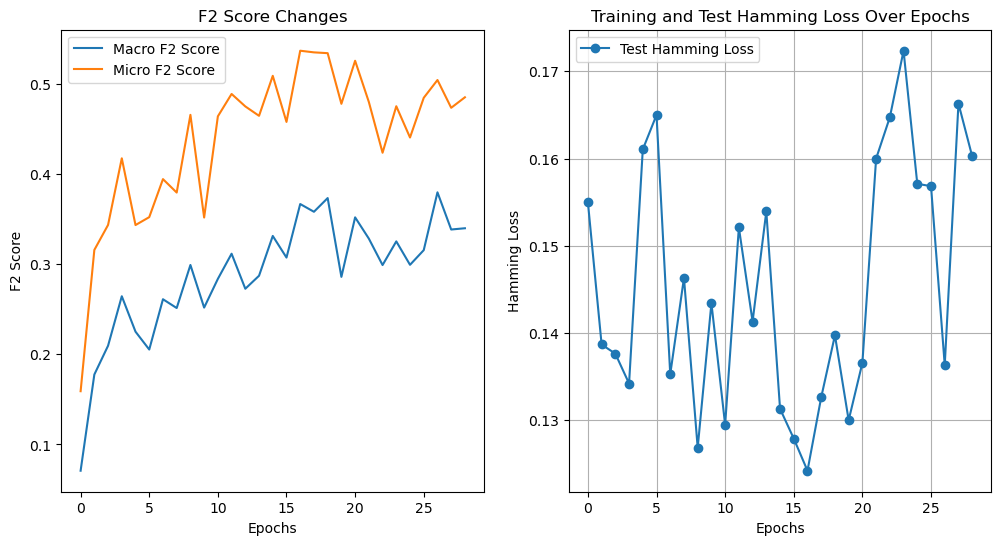

Best F2 sum (Macro F2 + Micro F2): 0.9076494152043807 at epoch 19
Macro F2: 0.373425709027419, Micro F2: 0.5342237061769617, Hamming Loss: 0.1397368311882019


In [6]:
#%% Resnet- 14channels

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models
from sklearn.metrics import fbeta_score
import numpy as np
from tqdm import tqdm

# 定义一个数据集类，用于处理和存储数据
class FixedDataset(Dataset):
    def __init__(self, loader, total_samples=15000, batch_size=3000, split_ratio=0.8):
        self.loader = loader
        self.features = []
        self.labels = []
        self.load_data(total_samples)
        self.train_batches, self.test_batches = self.create_batches(batch_size, split_ratio)

    def load_data(self, total_samples):
        count = 0
        progress_bar = tqdm(total=total_samples, desc="加载数据")
        for imgs, targets in self.loader:
            if count < total_samples:
                self.features.append(imgs[:, :14, :, :])  # 假设我们只需要前14个通道
                self.labels.append(targets)
                count += imgs.size(0)
                progress_bar.update(imgs.size(0))
            else:
                break
        progress_bar.close()
        self.features = torch.cat(self.features)[:total_samples]
        self.labels = torch.cat(self.labels)[:total_samples]
        print(f"总共加载了 {len(self.features)} 个样本")

    def create_batches(self, batch_size, split_ratio):
        # 划分数据集为训练集和测试集
        total_len = len(self.features)
        train_size = int(total_len * split_ratio)
        test_size = total_len - train_size

        # 创建训练数据批次
        train_indices = torch.arange(train_size).reshape(-1, batch_size)
        train_batches = [(self.features[idx], self.labels[idx]) for idx in train_indices]

        # 创建测试数据批次
        test_indices = torch.arange(train_size, total_len).reshape(-1, batch_size)
        test_batches = [(self.features[idx], self.labels[idx]) for idx in test_indices]

        return train_batches, test_batches

# 修改ResNet18以适应14通道输入
class ResNet18_14Channels(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(14, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

# 初始化模型和参数

num_classes = 19  # 示例类别数
model = ResNet18_14Channels(num_classes=num_classes)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_dataset = LMDBDataset(
        lmdb_file='datasets/dataload_op1_lmdb/train_B14.lmdb',
        transform=cvtransforms.Compose([cvtransforms.ToTensor()])
    )
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True,num_workers=0)

# 实例化数据集
total_samples = 1000
batch_size = 50
dataset = FixedDataset(train_loader, total_samples, batch_size)

# 获取训练批次和测试批次
train_batches = dataset.train_batches
test_batches = dataset.test_batches

# 训练模型并记录损失和F2分数

f2_macro_scores = []
f2_micro_scores = []
hammingloss = []
f2_sum_scores = []  # 存储 F2 宏观和微观分数之和
best_f2_sum = 0  # 最优 F2 分数和的初始值
best_epoch = 0  # 用于记录取得最佳 F2 分数和的 epoch
best_test_loss = float('inf')  # 初始化最佳测试损失为无穷大
best_details = {}

stopvalue = 10

def hamming_loss(y_true, y_pred, threshold=0.5):
    # 确保 y_pred 是 tensor
    y_pred = (y_pred > threshold).float()
    return (y_true != y_pred).float().mean()
    
for epoch in range(500):  # 训练 10 个 epoch
    print(f"Starting epoch {epoch+1}")
    model.train()
    epoch_train_loss = 0
    for inputs, targets in train_batches:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    epoch_train_loss /= len(train_batches)

    # 在测试集上评估模型
    model.eval()
    epoch_test_loss = 0
    all_preds = []
    all_targets = []
    test_hamming_loss = 0

    with torch.no_grad():
        test_hamming_loss = 0
        for inputs, targets in test_batches:  # 使用测试批次
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_test_loss += loss.item()
            
            preds = torch.sigmoid(outputs)
            all_preds.append(preds)
            all_targets.append(targets.cpu().numpy())
            current_hamming_loss = hamming_loss(targets, preds)
            test_hamming_loss += current_hamming_loss
    epoch_test_loss /= len(test_batches)  # 计算平均测试损失
    all_preds_cpu = [pred.cpu().numpy() for pred in all_preds]
    all_preds = np.vstack(all_preds_cpu)
    all_targets = np.vstack(all_targets)
    macro_f2 = fbeta_score(all_targets, all_preds > 0.5, beta=2, average='macro')
    micro_f2 = fbeta_score(all_targets, all_preds > 0.5, beta=2, average='micro')
    f2_macro_scores.append(macro_f2)
    f2_micro_scores.append(micro_f2)
    f2_sum = macro_f2 + micro_f2
    f2_sum_scores.append(f2_sum)
    
    test_hamming_loss /= len(test_batches)
    print(f'Epoch {epoch+1}, Test Hamming Loss: {test_hamming_loss}, Macro F2: {macro_f2}, Micro F2: {micro_f2}, F2 Sum: {f2_sum}')    
    hammingloss.append(test_hamming_loss)
    # 更新最优 F2 分数和
    if f2_sum > best_f2_sum:
        best_f2_sum = f2_sum
        best_epoch = epoch + 1
        best_details = {
            'epoch': epoch + 1,
            'macro_f2': macro_f2,
            'micro_f2': micro_f2,
            'hamming_loss': test_hamming_loss 
            }
        print(f"New best F2 sum: {best_f2_sum} at epoch {best_epoch}")
    
    # 早停判断
    if len(f2_sum_scores) > stopvalue:
        recent_best_f2_sum = max(f2_sum_scores[-stopvalue:])
        previous_best_f2_sum = max(f2_sum_scores[:-stopvalue])
        if recent_best_f2_sum <= previous_best_f2_sum:
            print("Early stopping triggered due to lack of improvement in F2 sum over the last 10 epochs.")
            break

# 绘制损失和F2分数图
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(f2_macro_scores, label='Macro F2 Score')
plt.plot(f2_micro_scores, label='Micro F2 Score')
plt.title('F2 Score Changes')
plt.xlabel('Epochs')
plt.ylabel('F2 Score')
plt.legend()

plt.subplot(1, 2, 2)
if isinstance(hammingloss[0], torch.Tensor):
    hammingloss = [hl.item() for hl in hammingloss]
plt.plot(hammingloss, label='Test Hamming Loss', marker='o')
plt.title('Training and Test Hamming Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Hamming Loss')
plt.legend()
plt.grid(True)


plt.show()

print(f'Best F2 sum (Macro F2 + Micro F2): {best_f2_sum} at epoch {best_epoch}')
print(f'Macro F2: {best_details["macro_f2"]}, Micro F2: {best_details["micro_f2"]}, Hamming Loss: {best_details["hamming_loss"]}')


The code below involves making the dataset, performing pca, and so on. Requires long running time and computer memory.
The result of the run is the npy file downloaded from the link in the readme.md

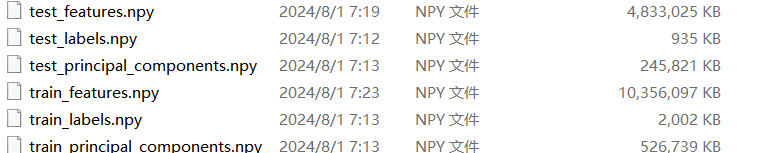

In [ ]:
#%% make train dataset
import numpy as np
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict

mlb = MultiLabelBinarizer(classes=NEW_LABELS)
mlb.fit([NEW_LABELS])  

features = []
labels = []

qualified_labels = set()

with torch.no_grad():
    for i, (imgs, target) in enumerate(train_loader):
        imgs = imgs.to(device)
        imgs = imgs[:, :14, :, :] if imgs.shape[1] > 14 else imgs

        feature = feature_model(imgs)
        batch_features = feature.view(feature.size(0), -1).cpu().numpy()
        batch_labels = [[NEW_LABELS[idx] for idx, label in enumerate(t) if label == 1] for t in target.cpu().numpy()]

        # 独立热编码标签
        batch_labels_encoded = mlb.fit_transform(batch_labels)

        features.append(batch_features)
        labels.append(batch_labels_encoded)  # 添加独立热编码后的标签数组

        print(f"After batch {i+1}: Features shape: {np.array(features).shape}, Labels collected: {len(labels)}")

features = np.vstack(features) if features else np.array([])
labels = np.vstack(labels) if labels else np.array([])  # 直接使用vstack堆叠

print("Accumulated features shape:", features.shape)
print("Number of labels collected:", labels.shape)


np.save('train_features.npy', features)  # 保存features数组
np.save('train_labels.npy', labels)      # 保存labels数组


In [ ]:
#%% make test dataset
import numpy as np
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict



# 初始化独立热编码器
mlb = MultiLabelBinarizer(classes=NEW_LABELS)
mlb.fit([NEW_LABELS])  

features = []
labels = []

qualified_labels = set()

with torch.no_grad():
    for i, (imgs, target) in enumerate(test_loader):
        imgs = imgs.to(device)
        imgs = imgs[:, :14, :, :] if imgs.shape[1] > 14 else imgs

        feature = feature_model(imgs)
        batch_features = feature.view(feature.size(0), -1).cpu().numpy()
        batch_labels = [[NEW_LABELS[idx] for idx, label in enumerate(t) if label == 1] for t in target.cpu().numpy()]

        # 独立热编码标签
        batch_labels_encoded = mlb.fit_transform(batch_labels)

        features.append(batch_features)
        labels.append(batch_labels_encoded)  # 添加独立热编码后的标签数组

        print(f"After batch {i+1}: Features shape: {np.array(features).shape}, Labels collected: {len(labels)}")

features = np.vstack(features) if features else np.array([])
labels = np.vstack(labels) if labels else np.array([])  # 直接使用vstack堆叠

print("Accumulated features shape:", features.shape)
print("Number of labels collected:", labels.shape)


np.save('test_features.npy', features)  # 保存features数组
np.save('test_labels.npy', labels)      # 保存labels数组

In [ ]:
#%% 从.npy文件加载数据
import numpy as np
#train_features = np.load('principal_components.npy',allow_pickle=True)
train_features = np.load('train_features.npy',allow_pickle=True)
train_labels = np.load('train_labels.npy',allow_pickle=True)

test_features = np.load('test_features.npy',allow_pickle=True)
test_labels = np.load('test_labels.npy',allow_pickle=True)


In [ ]:
#%% make PCA data 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib  # 用于模型持久化

# 对数据进行标准化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(train_features)

print("finish scaled")
#%% 进行pca
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib  

# 初始化PCA，选择主成分数量
pca = PCA(n_components=5000)
# 执行PCA
principal_components = pca.fit_transform(features_scaled)

print("PCA transformation complete.")
print("Shape of the principal components:", principal_components.shape)

# 保存主成分数组
np.save('test_principal_components.npy', principal_components)
